# Test the fully parallel propagation of the Rydberg Hamiltonian

This propagates only the drift Hamiltonian

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB, split_AB_blocks, split_diagonal_hamiltonian
from src.ham import rydberg_hamiltonian

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET
N_THREADS = 12  # number of cores on the machine

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
pulse = Pulse.read('./data/pulse_sig.dat')

In [11]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [12]:
qdyn_model = LevelModel()

In [13]:
schedule_fmt = "{row},{col},%s,1" % N_THREADS

In [14]:
for (i, H0) in enumerate(split_diagonal_hamiltonian(H[0], N_THREADS)):
    qdyn_model.add_ham(
        H0,
        op_unit='au',
        op_type='pot',
        schedule=schedule_fmt.format(row=(i + 1), col=1),
    )

In [15]:
qdyn_model.add_state(psi0, label='initial')

In [16]:
qdyn_model.add_state(psi_target, label='target')

In [17]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [18]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [19]:
RF = './rf_parallel_schedule_H0'

In [20]:
qdyn_model.write_to_runfolder(RF)

In [21]:
%%bash -s "$RF"
qdyn_prop_traj --version
time OMP_NUM_THREADS=12 qdyn_prop_traj --state-label=initial $1

QDYN 2.0dev revision 2b2fa92f1a71e2a8d932a667b7980c5428c8cce7 (rydbergparallel)
  features: no-check-cheby, no-check-newton, parallel-ham=DISJUNCT_COLUMN, use-mkl=false, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sat Aug 24 05:55:09 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Sat Aug 24 19:46:53 +0200 2019

*** Read config file ./rf_parallel_schedule_H0/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

Sat Aug 24 19:47:08 +0200 2019
***** END OF PROGRAM qdyn_prop_tr

1

real	0m15.227s
user	2m52.266s
sys	0m6.739s


In [22]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [23]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

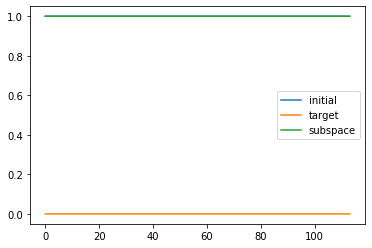

In [24]:
plot_population(pop_data)